In [1]:
import torch
import cv2, os
import matplotlib.pyplot as plt
import numpy as np
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F

from tqdm import tqdm
from time import time

In [2]:
%cd ..

/home/suetin/Projects/VSCode/UltrasoundCardiacReconstruction/HeartReconstruction


/home/suetin/Projects/VSCode/UltrasoundCardiacReconstruction/.venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


# 0. Constants

In [3]:
img_size = (256, 256)

batch_size = 4
valid_batch_size = 2
epochs = 12
n_print = 200
lr = 0.001

workers = 2
isCuda = True
device = torch.device("cuda:0" if (torch.cuda.is_available() and isCuda) else "cpu")
torch.backends.cudnn.benchmark = True
print("Device: {}".format(device))

model_saved_dir = "results/Unet3+"
if os.path.exists(model_saved_dir) == False:
    os.mkdir(model_saved_dir)

Device: cuda:0


# 1. Data

In [4]:
from src.scripts.DataLoaders import HeartLoader, get_image_filepaths, ImgForPlot

In [5]:
format = '.png'

train_path = "data/train/train"
test_path = "data/train/test"

img_train_paths = get_image_filepaths(os.path.join(train_path, "images"), format, as_mask=False)
img_test_paths = get_image_filepaths(os.path.join(test_path, "images"), format, as_mask=False)

msk_train_paths = get_image_filepaths(os.path.join(train_path, "masks"), format, as_mask=True)
msk_test_paths = get_image_filepaths(os.path.join(test_path, "masks"), format, as_mask=True)

len(img_train_paths), len(msk_test_paths)

(3475, 625)

Already numpy.array
Already numpy.array


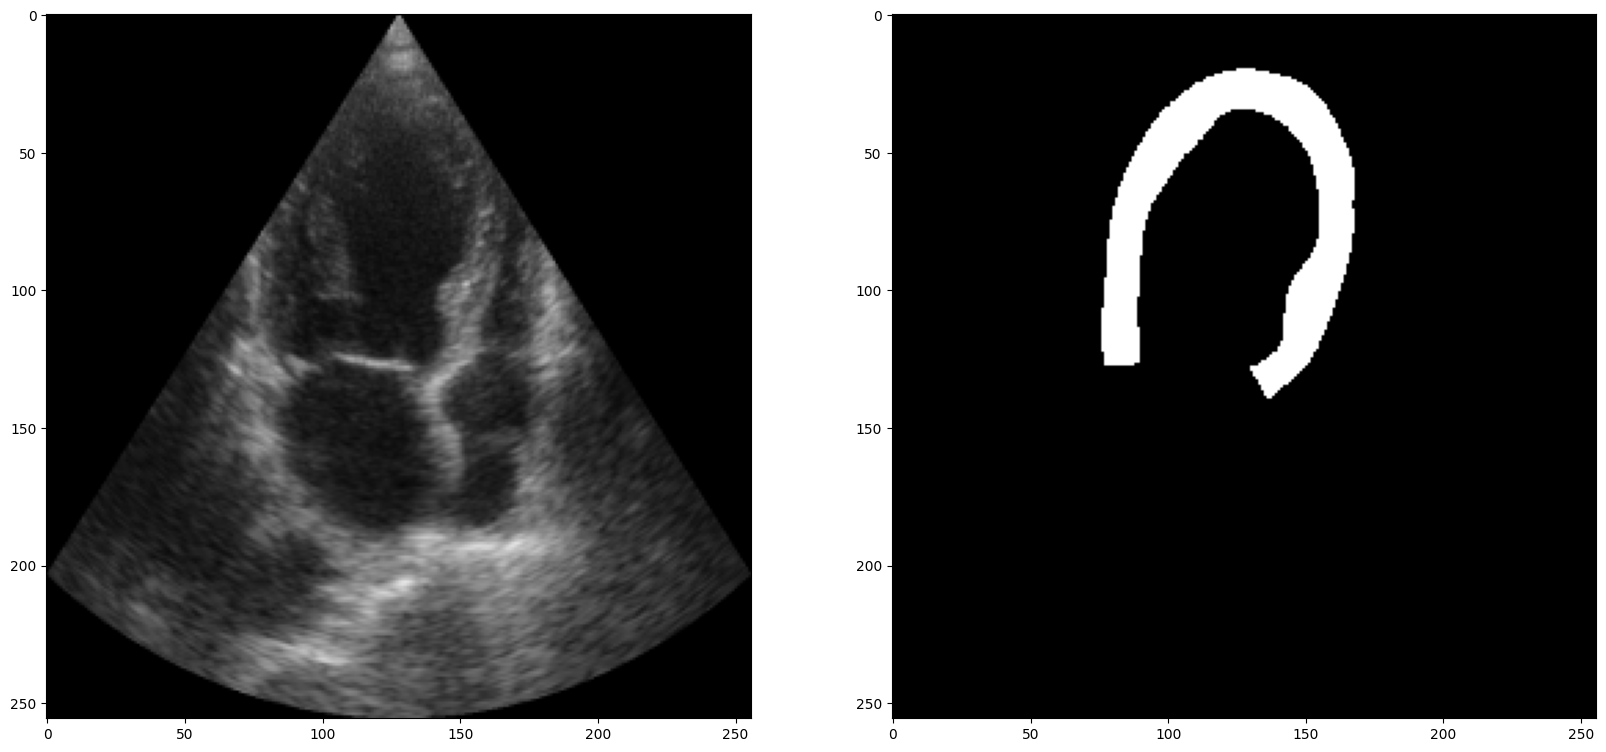

In [6]:
dataset = HeartLoader(img_train_paths, msk_train_paths, img_size)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=workers)

valid_dataset = HeartLoader(img_test_paths, msk_test_paths, img_size)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=valid_batch_size, shuffle=True, num_workers=workers)

im, m = dataset[777]

fig = plt.figure(figsize=(20,20))

plt.subplot(121)
plt.imshow(ImgForPlot(im));
plt.subplot(122)
plt.imshow(ImgForPlot(m), 'gray');

# 2. Model

In [7]:
# from src.scripts.models.Unet3plus import unet3plus
from src.scripts.models.U3plus import unet3plus
from torchvision.transforms import v2

img = v2.ToDtype(torch.float32, scale=True)(im)
img.shape, type(img)

((3, 256, 256), numpy.ndarray)

In [8]:
model_name = 'Unet3plus'

model = unet3plus(num_classes=1).cuda()

# inputs = torch.randn((1, 3, 512, 512))
# y1 = model(inputs.cuda())
# print(y1.shape)
# plt.imshow(ImgForPlot(y1[0]), 'gray');

# 3. Train


nvidia-settings -a GPUFanControlState=1 -a GPUTargetFanSpeed=90

In [9]:
# import numpy as np
# import matplotlib.pyplot as plt



# beta = 8
# def linear_cos(xx):
#     return beta * np.cos(xx) - (1/0.33 * xx)

# xx = np.arange(100)
# plt.plot(xx, (linear_cos(xx)*0.005) + 0.05)

# LR_START = 1e-5
# LR_MAX = 2e-3
# LR_RAMPUP_EPOCHS = 10
# LR_SUSTAIN_EPOCHS = 0
# LR_STEP_DECAY = 1 # 0.85
# ALPHA = 3

# def warmup_scheduler(epoch, lr):
#     if epoch < LR_RAMPUP_EPOCHS:
#         lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
#         # lr = 0.01
#     elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
#         lr = LR_MAX
#     else:
#         # lr = LR_MAX * LR_STEP_DECAY**((epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS)//3)
#         # lr = LR_MAX * LR_STEP_DECAY**((epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) // ALPHA)
#         lr = linear_cos(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) * LR_START + LR_MAX
#         lr = lr * LR_STEP_DECAY**((epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) // ALPHA)

#     return lr


# plt.plot(xx, [warmup_scheduler(x, 0.01) for x in xx])
# plt.show()

In [10]:
from src.scripts.losses import IoULoss, DiceBCELoss, DiceLoss


# IoU_loss = IoULoss()
DICE =  DiceLoss()
DBCE = DiceBCELoss()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [11]:
import math


LR_START = 0.001
T_alpha = 8   # Time constant, чем меньше тем быстрее убывает
LOW = 0.0002

def update_lr(epoch, T):
  # Decrease lr every T epochs
  new_lr = (LR_START-LOW) * np.exp(-epoch/T_alpha) + LOW  # lr * math.pow(0.5, epoch // T)
  print('Learning Rate: %.6f' % new_lr)
  for param_group in optimizer.param_groups:
    param_group['lr'] = new_lr

In [12]:
version = None

if version:
  loss_path = F"{model_saved_dir}/{model_name}_loss.txt"
  best_model_path = F"{model_saved_dir}/{model_name}_best.pt"
  model_path = F"{model_saved_dir}/{model_name}.pt"
else: 
  loss_path = F"{model_saved_dir}/{model_name}_loss_{version}.txt"
  best_model_path = F"{model_saved_dir}/{model_name}_best_{version}.pt"
  model_path = F"{model_saved_dir}/{model_name}_{version}.pt"

start_epoch = 0

if start_epoch == 0:
  losses = {'train': [], 'valid': []}
  best_loss = float("inf")
else:
  best_loss = min(losses['valid'])


for ep in range(start_epoch, epochs):
    update_lr(ep, 4)
    step, loss_sum = 0, 0.
    timestamp = time()
    for batch_idx, (input, target) in enumerate(dataloader, 0):
        input = input.to(device)
        target = target.to(device)
        step += 1
        
        # Train Model
        model.train()
        optimizer.zero_grad()
        
        out = model(input)
        # each_loss = [BCE(o.unsqueeze(1), target) for o in out]
        # loss = sum(each_loss)
        each_loss = [ DBCE(o, target) for o in out ]  
        loss = sum(each_loss)
        
        loss.backward()
        optimizer.step()

        # Append Loss
        losses['train'].append(loss.item())
        loss_sum += loss.item()

        if (batch_idx+1) % n_print == 0 or batch_idx == (len(dataloader)-1):
            print('[%2d/%2d][%4d/%4d] Train: %.4f (%ds)' % (ep+1, epochs, batch_idx+1, len(dataloader), loss_sum/step, time() - timestamp))
            step, loss_sum = 0, 0.
            timestamp = time()
      
    # Evaluate Model
    model.eval()
    step, loss_sum = 0, 0.
    timestamp = time()
    with torch.no_grad():
        for input, target in tqdm(valid_dataloader):
            out = model(input.to(device))[-1]
            if out.ndim == 3:
                out = out.unsqueeze(1)
            
            loss_sum += DICE(out, target.to(device)).item() * input.size(0)  # MAE(out, target.to(device)).item() * input.size(0)
            step += input.size(0)
      
        val_loss = loss_sum / step
        losses['valid'].append(val_loss)
        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), best_model_path)

    print('[%2d/%2d] Valid: %.4f (Best: %.4f) (%ds)' % (ep+1, epochs, val_loss, best_loss, time() - timestamp))

    torch.save(model.state_dict(), model_path)
    with open(loss_path, 'wb') as f:
        pickle.dump(losses, f)
    
    print("Saved model completely!")

Learning Rate: 0.001000
